# day 3 tutorial

Run the whole notebook by selecting "Restart & Run All" from the "Kernel" menu (above).

**TO RUN LOCALLY users need to install ipywidgets and ipyleaflet and enable the widget extension for jupyter:**
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```
**notes:**
* old code that Yaxing might still want to use is at bottom


In [1]:
import os
import json
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

# widgets/map colors
import ipywidgets as wg
import ipyleaflet as mwg
import math
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# miscellaneous settings
smap_res = 9
basemap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)

# this suppresses warnings related to browser compatibility
import warnings
warnings.filterwarnings('ignore')

## soil moisture visualizer datasets

In [2]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="Column fieldname", header=0)
smvds

,Description,Units
Column fieldname,,
SoilSCAPE_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
SoilSCAPE_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
AirMOSS_in-ground_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
AirMOSS_in-ground_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
COSMOS_surface,Mean volumetric (%) soil moisture at 0-5 cm so...,m3/m3
COSMOS_rootzone,Mean volumetric (%) soil moisture at 0-100 cm ...,m3/m3
AirMOSS_L2_3_surface,Mean volumetric (%) soil moisture at 0 cm soil...,m3/m3
AirMOSS_L2_3_rootzone,Mean volumetric (%) soil moisture at 0-30cm so...,m3/m3
AirMOSS_L4_rootzone,Mean volumetric (%) soil moisture at 0-100cm s...,m3/m3


## converting soil moisture visualizer output to xr.Dataset

In [3]:
f = "docs/daily-smap-ORNL-DAAC-PccIuo.txt"          # example smv output
df = pd.read_csv(f, header=4, index_col="time")
df.index = pd.to_datetime(df.index)

datasets = list(df)
df.head(5)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;


In [4]:
def getxr(series, lat=None, lon=None):

    # split columns into more columns; give names
    t = series.str.split(";", n = 2, expand=True)
    t.columns = ["Min", "Mean", "Max"]

    # replace empty strings w numpy.nan; all dtypes to float
    for col in t.columns:
        t[col].loc[t[col]==''] = np.nan
        t[col] = t[col].astype(float)
        
    # make an xarray.Dataset
    x = xr.Dataset(t)
    x.attrs = smvds.loc[series.name].to_dict()
    x.attrs['Dataset'] = series.name
    
    # if lat and lon are given, add coordinates
    if all([lat,lon]):
        x.coords['lat'], x.coords['lat'] = lat, lon
    
    return(x)

# make dictionary of xr.Datasets; print one
AirMOSS_L4_rootzone = getxr(df['AirMOSS_L4_rootzone'])
AirMOSS_L4_rootzone

<xarray.Dataset>
Dimensions:  (time: 2354)
Coordinates:
  * time     (time) datetime64[ns] 2012-09-20 2012-09-21 ... 2019-03-01
Data variables:
    Min      (time) float64 4.86 9.55 9.34 9.14 8.95 ... nan nan nan nan nan
    Mean     (time) float64 7.16 9.6 9.49 9.38 9.27 9.18 ... nan nan nan nan nan
    Max      (time) float64 9.2 9.67 9.57 9.52 9.49 9.46 ... nan nan nan nan nan
Attributes:
    Units:        m3/m3
    Description:  Mean volumetric (%) soil moisture at 0-100cm soil depth
    Dataset:      AirMOSS_L4_rootzone

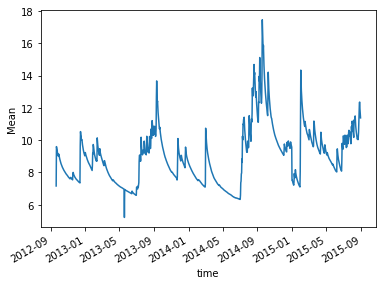

In [5]:
%matplotlib inline
AirMOSS_L4_rootzone['Mean'].plot()

## requests

In [6]:
r = requests.get(
    "https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=32.8129&ln=-109.4379&d=smap",
    cookies=dict(ORNL_DAAC_USER_NUM="1"))

r.text

"Filename: daily-smap-ORNL-DAAC-XXXXXX\nData_Set_Name: Daily soil moisture and ancillary datasets. Data columns are delineated by commas. The values in each column when separated by semicolons represent the daily range as 'min; mean; max'.\nLocation: 32.8129, -109.4379\nCitation: ORNL DAAC. 2017. Soil Moisture Visualizer. ORNL DAAC, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1366\n\n\ntime,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,tmax,tmin,ET,LST_Day,LST_Night,EVI,AirMOSS_in-ground_surface,AirMOSS_in-ground_rootzone,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl\r\n2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;13.59;,;24.89;\r\n2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,

In [7]:
lat, lon = StringIO(r.text).readlines()[2].split("Location: ")[1].strip().split(", ")
df = pd.read_csv(StringIO(r.text), header=4, index_col="time")
df.head(10)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl
time,,,,,,,,,,,,,,,,,,,,,
2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;13.59;,;24.89;
2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-03,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-04,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-05,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-06,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-07,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2002-04-08,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;20.77;,;27.37;
2002-04-09,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;


**This function will submit 1 request to the SMV and parse the returned data to a data frame:**

In [8]:
def smvrequest(id,lat,lon,d="smap"):
    url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?lt={lat}&ln={lon}&d={d}"
    
    r = requests.get(
        url.format(
            lat=lat, 
            lon=lon, 
            d=d), cookies=dict(ORNL_DAAC_USER_NUM="1"))
    
    df = pd.read_csv(StringIO(r.text), header=4, index_col="time")
    df.index = pd.to_datetime(df.index)
    
    return(df)

-------------------------------------------------
# EASE Grid
Spatial queries to the Soil Moisture Visualizer return data corresponding to 9- by 9-km cells within the EASE grid system.

Read about the EASE grid at the NSIDC's web page:        
https://nsidc.org/data/ease


Two binary files contain the arrays corresponding to global EASE grid centroid latitudes and longitudes, respectively.         

**Open the two files and read into `numpy` arrays:**

In [9]:
lats = "docs/EASE2_M09km.lats.3856x1624x1.double"
lons = "docs/EASE2_M09km.lons.3856x1624x1.double"

# read the files to two numpy arrays
lat_array = np.fromfile(lats, dtype=np.float64).flatten()
lon_array = np.fromfile(lons, dtype=np.float64).flatten()

# zip the arrays with np.dstack
c = np.dstack((lon_array, lat_array))[0]
print("Array shape: "+str(c.shape))
c

Array shape: (6262144, 2)


array([[-179.9533195 ,   84.6564188 ],
       [-179.85995851,   84.6564188 ],
       [-179.76659751,   84.6564188 ],
       ...,
       [ 179.76659751,  -84.6564188 ],
       [ 179.85995851,  -84.6564188 ],
       [ 179.9533195 ,  -84.6564188 ]])

The most straightforward way to select coordinates inside a polygon is to first index the coordinate array using the polygon extent.

**Select a 2-dimensional array of EASE grid centroids using some arbitrary latitude, longitude bounds:** 

In [10]:
selection = c[(-90<lon_array) & (lon_array<-85) & (25<lat_array) & (lat_array<30)]
selection

array([[-89.9533195 ,  29.94568162],
       [-89.85995851,  29.94568162],
       [-89.76659751,  29.94568162],
       ...,
       [-85.19190871,  25.02339698],
       [-85.09854772,  25.02339698],
       [-85.00518672,  25.02339698]])

**Simple function uses the logic above to select an array of coordinates within bounding extent of the polygon:**

In [11]:
def get_ease(geom):
    
    # geom.bounds method returns a tuple of bounding coordinates:
    sel_minlon, sel_minlat, sel_maxlon, sel_maxlat = geom.bounds
    
    # index the xy array with bool conditions based on extent
    sel_ease = c[(sel_minlon<lon_array) & (lon_array<sel_maxlon) & 
                 (sel_minlat<lat_array) & (lat_array<sel_maxlat)]
    
    # further reduce to pts contained within the selected geometry
    sel_ease_poly = [
        pt for pt in sel_ease if geom.contains(Point(pt[0], pt[1]))]
    
    return(sel_ease_poly)

---------------------------------------------
# Reading and organizing ESRI Shapefile data using `geopandas`:

In [12]:
# read shapefile to geodataframe
gdf = gpd.GeoDataFrame.from_file("sites/Sites_lf.shp")  

# get geodataframe as wgs84l get centroid of each polygon
gdf = gdf.to_crs({'init': 'epsg:4326'})
gdf['centroid'] = [(p.y, p.x) for p in gdf.centroid]

# make list of colors using matplotlib's colormapper
gdf['style'] = [{
    'color': colors.rgb2hex(d[0:3]), 
    'fillColor': colors.rgb2hex(d[0:3]), 
    'weight': 1, 'fillOpacity': 0.5
} for d in cm.Set3(np.linspace(0.0,1.0,len(gdf)))]

# get geometries from geodataframe as python dictionary; get bounds
geodict = json.loads(gdf.to_json())
bnds, series = gdf.bounds, gdf['geometry']

# get extent and centroid for whole file
minx, maxx = min(bnds['minx']), max(bnds['maxx'])
miny, maxy = min(bnds['miny']), max(bnds['maxy'])
centroid = ((maxy+miny)/2, (maxx+minx)/2)

# display first two rows of geodataframe
gdf.head(2)

,OBJECTID,RANGERDIST,REGION,FORESTNUMB,DISTRICTNU,DISTRICTOR,FORESTNAME,DISTRICTNA,GIS_ACRES,SHAPE_Leng,...,STD_29,STD_30,STD_31,STD_32,STD_33,STD_34,STD_35,geometry,centroid,style
0,61,99030501010343,03,05,01,030501,Coronado National Forest,Douglas Ranger District,434025.200,3.963602,...,446.146563,453.982071,557.405375,339.841942,599.562885,470.501168,343.082608,(POLYGON ((-109.2462605499999 32.0543309500000...,"(31.774734099094083, -109.3275890439515)","{'fillColor': '#8dd3c7', 'fillOpacity': 0.5, '..."
1,62,99030503010343,03,05,03,030503,Coronado National Forest,Sierra Vista Ranger District,321534.997,2.854066,...,502.615547,430.908201,701.371540,272.786808,445.029396,525.713796,242.986111,(POLYGON ((-110.6378639499999 31.6445072200000...,"(31.505073066518996, -110.53696719971326)","{'fillColor': '#ffffb3', 'fillOpacity': 0.5, '..."


**Test the function for selecting EASE grid points using a site from the USFS shapefile:**

In [13]:
get_ease(gdf.iloc[8].geometry)[:5]

[array([-107.22510373,   37.91860119]),
 array([-107.13174274,   37.91860119]),
 array([-107.03838174,   37.91860119]),
 array([-106.94502075,   37.91860119]),
 array([-106.85165975,   37.91860119])]

*Note: the double brackets `{{}}` are required because Python reserves those chars for string formatting. GeoJSON strings don't have the double brackets.*

-----------------------------------------
# Building a UI in Jupyter with `ipywidgets` and `ipyleaflet`
The next couple cells are pretty long, but they provide some nice functionality for interactive query and display of the SMV data. The cell below initializes the widgets that we'll draw in the cells to come:

1. Make `ipyleaflet` map widget
2. Make map layer of USFS sites from the `geopandas` data frame created above
3. Make a submit button to begin sending series of requests to the SMV
4. Make progress bar to monitor progress of the requests

In [14]:
m = mwg.Map(layers=(basemap,), center=(33, -109), zoom=6, scroll_wheel_zoom=True)  # 1

layer = mwg.GeoJSON(                                                               # 2
    data=geodict, 
    hover_style={'color': "white", 'weight': 2, 'fillOpacity': 0.5}) 

submit = wg.Button(                                                                # 3
    description='Submit', 
    disabled=True, 
    button_style='success',    
    tooltip='Click to submit requests for each EASE grid point.')

progress_bar = wg.IntProgress(                                                     # 4
    description="Progress: ", layout=wg.Layout(width="99%"))

sample = wg.Select(disabled=False, description='Sample:')

## add click handler; display map
click handler calls `get_ease` upon polygon click, reduces array of ease grid centroids using polygon extent, uses shapely `contains()` to determine if point is inside polygon (geopandas is basically pandas with shapely geometry column), makes feature and adds to layer group.

*note: `samples` will be a global variable that is updated with the most recently selected list of EASE grid sample coordinates*

In [15]:
# containers for sample data and pt layers; global variables
samples = None
samplepts = None


def button_click_handler(b):
    global samples
    global samplepts
    m.remove_layer = samplepts

    progress_bar.min, progress_bar.max  = 0, len(samples.keys()) # set progress bar min, max                                 
    progress_bar.value = 0                                       # reset progess bar to 0

    spts = []
    for i, pt in samples.items():
        progress_bar.value += 1

        spt = mwg.CircleMarker(location=(pt[1], pt[0]))
        spts.append(spt)
        m.add_layer(spt)
        
        df = smvrequest(i, pt[1], pt[0])
        xrds = {v: getxr(
            df[v], 
            lat=pt[1], 
            lon=pt[0]
        ) for v in list(df)}
        samples[i] = xrds

submit.on_click(button_click_handler)


def layer_click_handler(**kwargs):
    global samples
    global samplepts

    # click callback returns two separate objects; differentiate
    if "id" not in kwargs.keys():
        return(None)
    
    # get geopandas row corresponding to clicked polygon; get the geometry
    g = gdf.iloc[int(kwargs['id'])]
    geom = g.geometry
    centroid = geom.centroid
    
    # center and zoom the map
    m.center, m.zoom = (centroid.y, centroid.x), 9
    
    # use our function to select an array of coords within geom extent
    easepts = get_ease(geom)
    
    # iterate over array of coordinates and make point layers
    samples, spts = {}, []
    for i, pt in enumerate(easepts):
        spts.append(mwg.CircleMarker(
            location=(pt[1], pt[0]), stroke=False,
            radius=5, fill_color="black", fill_opacity=0.6))
        samples[i] = pt
    samplepts = mwg.LayerGroup(layers=tuple(spts))
    m.add_layer(samplepts)
    
    submit.disabled = False

**Now add the USFS layer and display the widgets:**

In [16]:
layer.on_click(layer_click_handler)
m.add_layer(layer)
wg.VBox([m, wg.HBox([submit, progress_bar])])

## the most recently requested data is stored in the `samples` dictionary

In [93]:
plotable = {}
for v in samples[0].keys():
    if not np.isnan(samples[0][v]['Mean'].mean().data):
        plotable[v] = samples[0][v]
sample.options = list(plotable.keys())
sample.value = list(plotable.keys())[0]
print(plotable.keys())

dict_keys(['AirMOSS_L4_rootzone', 'GPP_mean', 'tmin', 'AirMOSS_L2_3_rootzone', 'SMAP_surface', 'NEE_mean', 'ET', 'AirMOSS_L2_3_surface', 'prcp', 'tmax', 'EVI', 'GRACE_surface_pctl', 'SMAP_rootzone', 'GRACE_rootzone_pctl', 'LST_Day'])


<IPython.core.display.Javascript object>


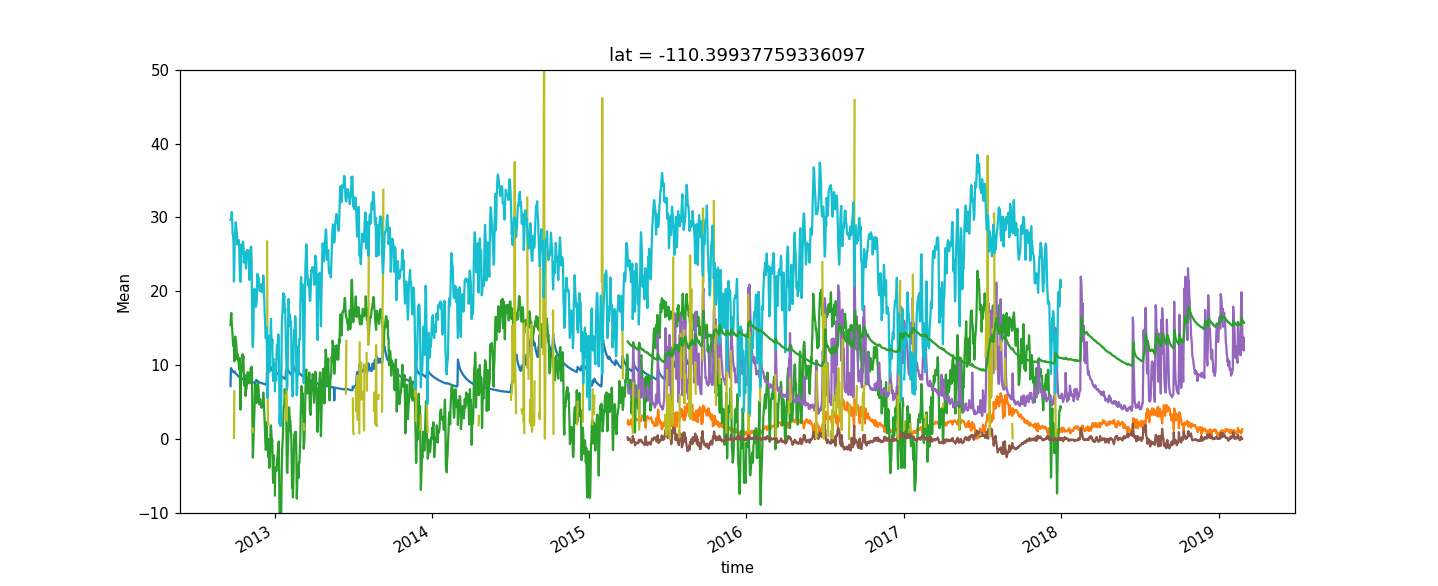

In [94]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 5]

fig = plt.figure()
for name, data in plotable.items():
    data['Mean'].plot()

plt.ylim(top=50, bottom=-10)
plt.draw()

In [82]:
plt.ylim()

(-29.167499999999997, 330.6975)

<IPython.core.display.Javascript object>


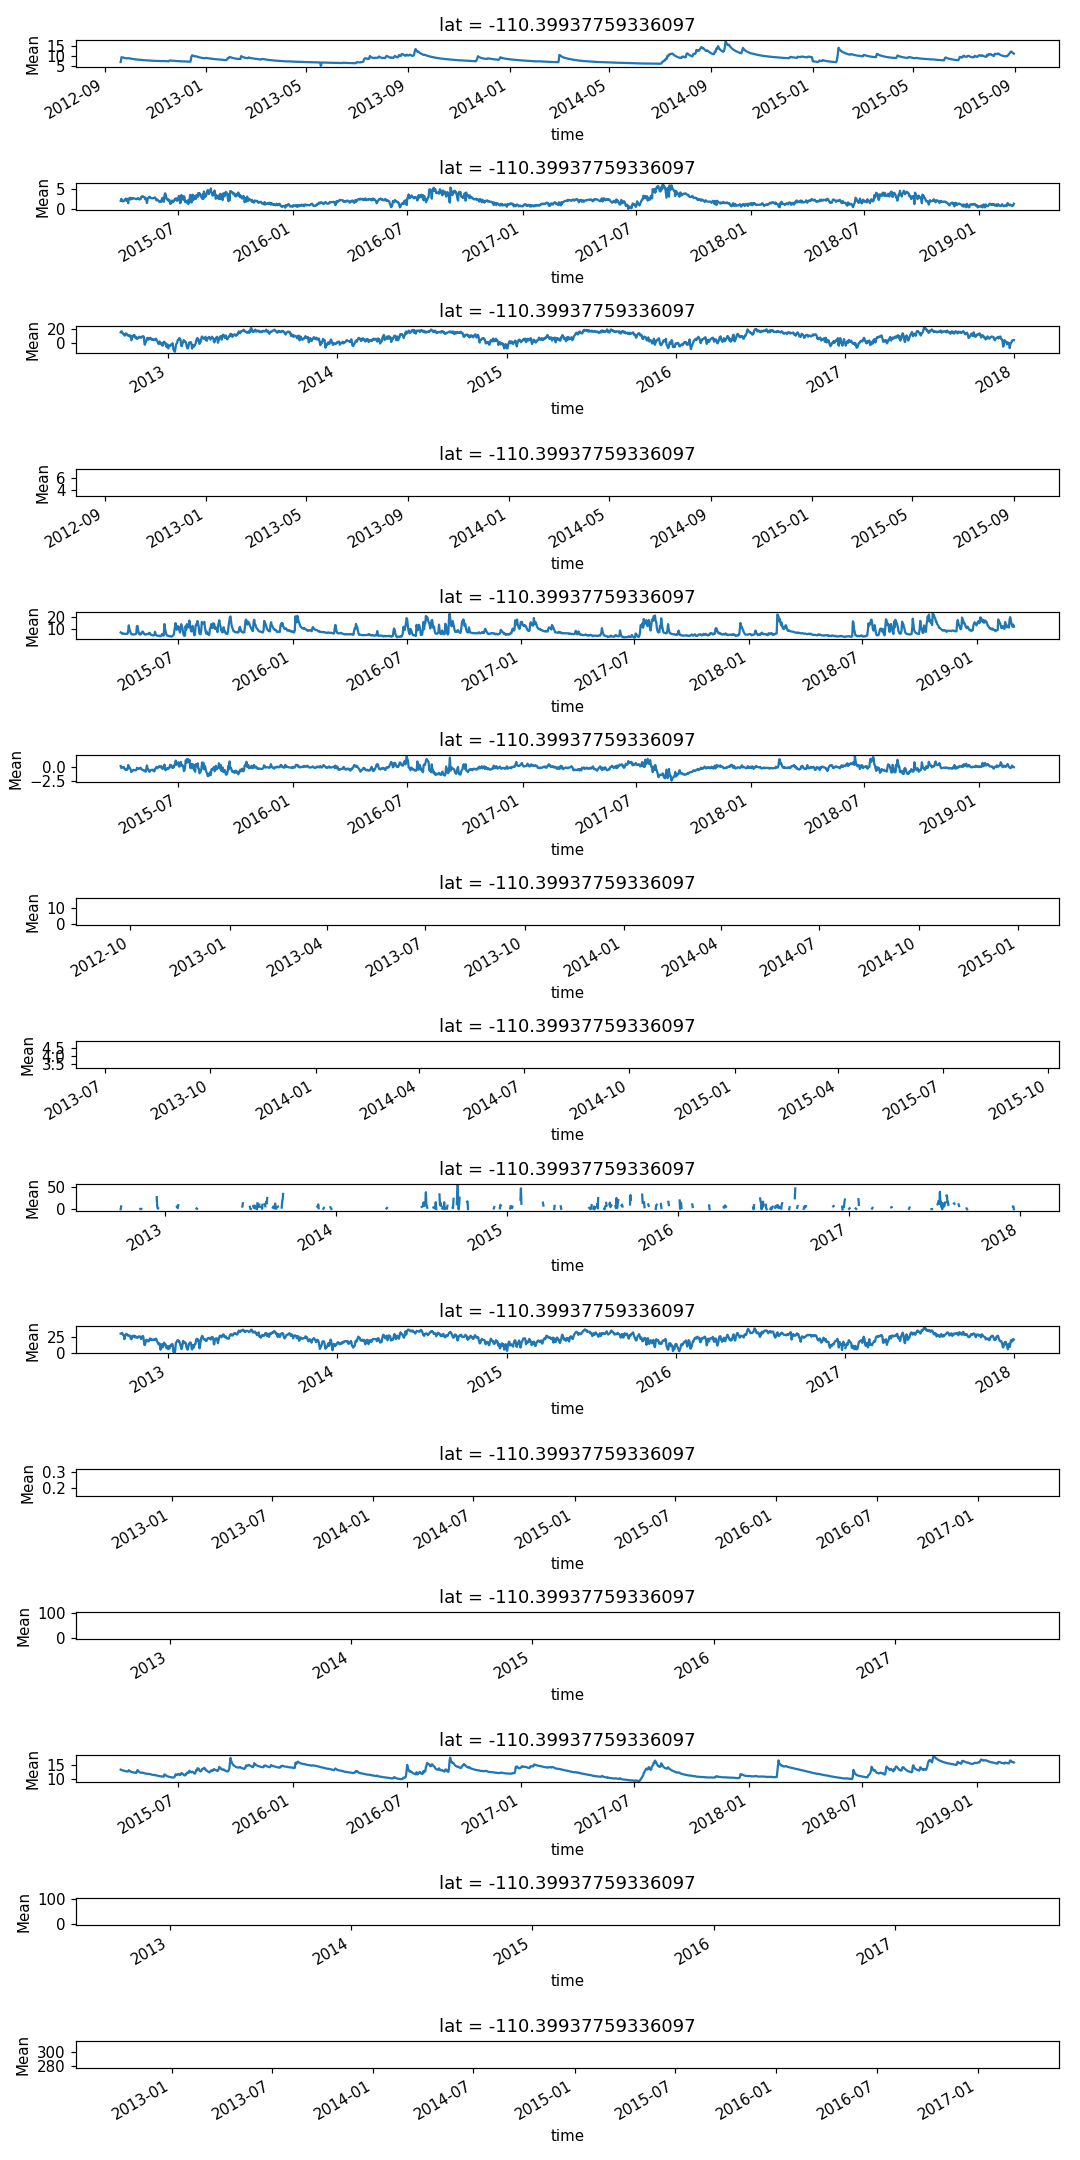

In [70]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 20]

fig, axes = plt.subplots(nrows=len(plotable))
for i, dataset in enumerate(plotable):
    data = plotable[dataset]
    data['Mean'].plot(ax=axes[i])

plt.set_yscale('log')
plt.tight_layout()
plt.draw()

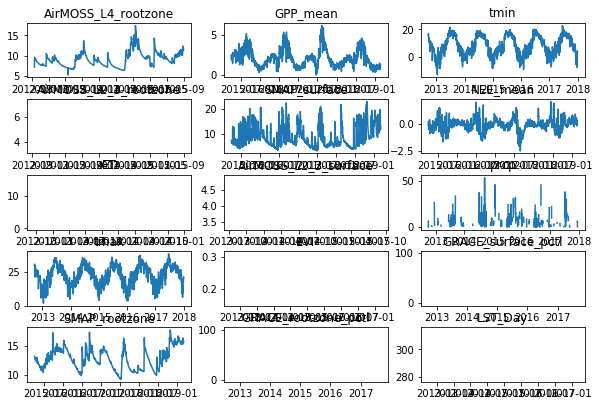

In [52]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# define the figure size and grid layout properties
figsize = (10, 8)
cols = 3
gs = gridspec.GridSpec( // cols + 1, cols)
gs.update(hspace=0.4)

fig = plt.figure(figsize=figsize)
ax = []
for i, dataset in enumerate(plottable):
    data = plottable[dataset]
    row = (i // cols)
    col = i % cols
    ax.append(fig.add_subplot(gs[row, col]))
    ax[-1].set_title(dataset)
    #ax[-1].set_xscale('log')
    #ax[-1].set_yscale('log')
    ax[-1].plot(data.time.data, data.Mean.data)
fig.tight_layout()

In [50]:
samples[0]['SMAP_rootzone'].Mean.data

array([  nan,   nan,   nan, ..., 15.81, 15.88, 15.73])

In [ ]:
samples[0]['SMAP_rootzone']['Mean']

In [ ]:

sample

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw()

interact(update);



In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2)

air1d.plot(ax=axes[0])
air1d.plot.hist(ax=axes[1])

plt.tight_layout()

plt.draw()



In [ ]:
test.update({1: None})
test

# old code
**maybe we don't display the hovers. it's kinda hack-y implementation. ipyleaflet map widget doesn't have great options for this type of interaction. this is the purged hover handler ocde:**
```
def hover_handler(event=None, id=None, properties=None):
    if len(m.layers)==3:
        m.remove_layer(m.layers[-1])

    nyears = len([key for key in properties.keys() if "MEAN" in key])
    data = {'year': [], 'mean': [], 'std': []}
    for i in range(1,nyears):
        data['year'].append(1980+i)
        data['mean'].append(properties["MEAN_"+str(i)])
        data['std'].append(properties["STD_"+str(i)])
    df = pd.DataFrame(data)
        
    popup = mwg.Popup(location=properties['centroid'], 
                      child=wg.HTML("{put some info here}"), 
                      auto_close=True,
                      class_name="custom")
    m.add_layer(popup)
    
layer.on_hover(hover_handler)
m.add_layer(layer)
m
```
**purged imports:**
```
import math
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3
mpl.rcParams['figure.figsize'] = [8, 7]
```

**layer group:**
```
# make layer group
point_group = mwg.LayerGroup(layers=tuple(point_features))
```

We'll use GeoJSON strings to add points to the map, too.

**GeoJSON point features look like this:**

In [ ]:
geojsonpt = '''
{{
    "type": "Feature",
    "properties": {properties},
    "geometry": {{
        "type": "Point",
        "coordinates": [{lon},{lat}]
    }}
}}
'''
print(geojsonpt.format(lat="30", lon="-90", properties="{}"))